### Imports

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from os import listdir, environ
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
print(tf.version)
print(tf.config.list_physical_devices('GPU'))

<module 'tensorflow._api.v2.version' from 'C:\\Users\\nicol\\anaconda3\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# For reproducible results
seed = 42
environ['PYTHONHASHSEED'] = str(seed)
tf.keras.utils.set_random_seed(42)  
tf.config.experimental.enable_op_determinism()

### Data 

In [3]:
# Constants
val_size = 0.2
data_path = 'public_data.npz'

In [4]:
# Read data
plants = np.load(data_path, allow_pickle=True)
X = plants['data']
y = plants['labels']

# Normalize image pixel values to a float range [0, 1]
X = (X / 255).astype(np.float32)

# Convert labels to categorical format using one-hot encoding
label_encoding = {'healthy': 0, 'unhealthy': 1}
y = np.array([label_encoding[label] for label in y])
y = tfk.utils.to_categorical(y, num_classes=2)

# Split into train and validation (hidden test set on codalab)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=val_size, stratify=np.argmax(y,axis=1))

# Convert labels to categorical format using one-hot encoding
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(4160, 96, 96, 3) (1040, 96, 96, 3) (4160, 2) (1040, 2)


In [5]:
# Create an image data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,       # Random rotations
    width_shift_range=0.2,   # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,         # Random shears
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Random horizontal flips
    fill_mode='nearest'      # Strategy for filling in newly created pixels
)

# Compute quantities required for featurewise normalization
datagen.fit(X_train, seed=seed)

### ML

In [6]:
# Model parameters 
input_shape = X.shape[1:] 
output_shape = y.shape[1] 
batch_size = 64     
epochs = 1000
dout = 0.2

In [7]:
## Model based on LeNet-5 architecture
# > Expanded receptive field (extra conv. and maxpooling at beginning of FEN)
# > Added dropout layers
# > using ReLU activations
model = tfk.models.Sequential([
    tfkl.Input(shape=input_shape, name='input'),
    tfkl.Conv2D(filters=6, kernel_size=(7,7), padding='same', activation='relu', name='conv1'),   
    tfkl.MaxPooling2D(pool_size=(3,3), name='mp1'),                                              
    tfkl.Conv2D(filters=6, kernel_size=(5,5), padding='valid', activation='relu', name='conv2'),  
    tfkl.MaxPooling2D(pool_size=(2,2), name='mp2'),                                               
    tfkl.Conv2D(filters=16, kernel_size=(5,5), padding='valid', activation='relu', name='conv3'),
    tfkl.MaxPooling2D(pool_size =(2,2), name='mp3'),                                              
    tfkl.Flatten(name='flatten'),
    tfkl.Dense(units=512, activation='relu', name='dense1'),
    tf.keras.layers.Dropout(rate=dout),
    tfkl.Dense(units=256, activation='relu', name='dense2'),
    tf.keras.layers.Dropout(rate=dout),
    tfkl.Dense(units=output_shape, activation='softmax', name='Output')
])

# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 96, 96, 6)         888       
                                                                 
 mp1 (MaxPooling2D)          (None, 32, 32, 6)         0         
                                                                 
 conv2 (Conv2D)              (None, 28, 28, 6)         906       
                                                                 
 mp2 (MaxPooling2D)          (None, 14, 14, 6)         0         
                                                                 
 conv3 (Conv2D)              (None, 10, 10, 16)        2416      
                                                                 
 mp3 (MaxPooling2D)          (None, 5, 5, 16)          0         
                                                                 
 flatten (Flatten)           (None, 400)               0

In [8]:
# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model and save its history
history = model.fit(
    datagen.flow(X_train, y_train, batch_size, seed=seed),
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
).history

# Save the trained model
model.save('mark_IV.h5')

Epoch 1/1000
65/65 [==============================] - 10s 108ms/step - loss: 0.6617 - accuracy: 0.6151 - val_loss: 0.6446 - val_accuracy: 0.6154
Epoch 2/1000
65/65 [==============================] - 7s 103ms/step - loss: 0.6271 - accuracy: 0.6445 - val_loss: 0.6466 - val_accuracy: 0.6019
Epoch 3/1000
65/65 [==============================] - 8s 123ms/step - loss: 0.6281 - accuracy: 0.6522 - val_loss: 0.6409 - val_accuracy: 0.6452
Epoch 4/1000
65/65 [==============================] - 8s 123ms/step - loss: 0.6029 - accuracy: 0.6687 - val_loss: 0.6115 - val_accuracy: 0.6587
Epoch 5/1000
65/65 [==============================] - 8s 122ms/step - loss: 0.5913 - accuracy: 0.6880 - val_loss: 0.6088 - val_accuracy: 0.6577
Epoch 6/1000
65/65 [==============================] - 8s 124ms/step - loss: 0.5892 - accuracy: 0.6731 - val_loss: 0.6037 - val_accuracy: 0.6702
Epoch 7/1000
65/65 [==============================] - 8s 122ms/step - loss: 0.5749 - accuracy: 0.6868 - val_loss: 0.5668 - val_accuracy

65/65 [==============================] - 8s 125ms/step - loss: 0.4881 - accuracy: 0.7594 - val_loss: 0.5110 - val_accuracy: 0.7548
Epoch 58/1000
65/65 [==============================] - 8s 123ms/step - loss: 0.4858 - accuracy: 0.7615 - val_loss: 0.5714 - val_accuracy: 0.7404
Epoch 59/1000
65/65 [==============================] - 8s 124ms/step - loss: 0.4890 - accuracy: 0.7671 - val_loss: 0.5544 - val_accuracy: 0.7269
Epoch 60/1000
65/65 [==============================] - 8s 124ms/step - loss: 0.4797 - accuracy: 0.7697 - val_loss: 0.5067 - val_accuracy: 0.7471
Epoch 61/1000
65/65 [==============================] - 8s 125ms/step - loss: 0.4752 - accuracy: 0.7707 - val_loss: 0.5285 - val_accuracy: 0.7481
Epoch 62/1000
65/65 [==============================] - 8s 125ms/step - loss: 0.4653 - accuracy: 0.7784 - val_loss: 0.5018 - val_accuracy: 0.7673
Epoch 63/1000
65/65 [==============================] - 8s 123ms/step - loss: 0.4757 - accuracy: 0.7733 - val_loss: 0.5395 - val_accuracy: 0.7279

65/65 [==============================] - 8s 122ms/step - loss: 0.4370 - accuracy: 0.7906 - val_loss: 0.4657 - val_accuracy: 0.7971
Epoch 114/1000
65/65 [==============================] - 8s 122ms/step - loss: 0.4365 - accuracy: 0.7952 - val_loss: 0.4608 - val_accuracy: 0.7933
Epoch 115/1000
65/65 [==============================] - 8s 123ms/step - loss: 0.4542 - accuracy: 0.7861 - val_loss: 0.4898 - val_accuracy: 0.7846
Epoch 116/1000
65/65 [==============================] - 8s 123ms/step - loss: 0.4408 - accuracy: 0.7889 - val_loss: 0.4650 - val_accuracy: 0.7798
Epoch 117/1000
65/65 [==============================] - 8s 123ms/step - loss: 0.4297 - accuracy: 0.7974 - val_loss: 0.4584 - val_accuracy: 0.7885
Epoch 118/1000
65/65 [==============================] - 8s 123ms/step - loss: 0.4324 - accuracy: 0.7971 - val_loss: 0.4605 - val_accuracy: 0.7885
Epoch 119/1000
65/65 [==============================] - 8s 122ms/step - loss: 0.4323 - accuracy: 0.7986 - val_loss: 0.4719 - val_accuracy: 

65/65 [==============================] - 8s 119ms/step - loss: 0.4072 - accuracy: 0.8168 - val_loss: 0.4467 - val_accuracy: 0.7923
Epoch 170/1000
65/65 [==============================] - 8s 122ms/step - loss: 0.4106 - accuracy: 0.8103 - val_loss: 0.4644 - val_accuracy: 0.7885
Epoch 171/1000
65/65 [==============================] - 8s 121ms/step - loss: 0.4210 - accuracy: 0.8041 - val_loss: 0.4967 - val_accuracy: 0.7692
Epoch 172/1000
65/65 [==============================] - 8s 122ms/step - loss: 0.4238 - accuracy: 0.8055 - val_loss: 0.4626 - val_accuracy: 0.7933
Epoch 173/1000
65/65 [==============================] - 8s 121ms/step - loss: 0.4169 - accuracy: 0.8077 - val_loss: 0.4771 - val_accuracy: 0.7837
Epoch 174/1000
65/65 [==============================] - 8s 122ms/step - loss: 0.4202 - accuracy: 0.8062 - val_loss: 0.4557 - val_accuracy: 0.7913
Epoch 175/1000
65/65 [==============================] - 8s 121ms/step - loss: 0.4141 - accuracy: 0.8094 - val_loss: 0.4363 - val_accuracy: 

65/65 [==============================] - 8s 121ms/step - loss: 0.4022 - accuracy: 0.8142 - val_loss: 0.4837 - val_accuracy: 0.7875
Epoch 226/1000
65/65 [==============================] - 8s 122ms/step - loss: 0.3781 - accuracy: 0.8267 - val_loss: 0.4451 - val_accuracy: 0.8096
Epoch 227/1000
65/65 [==============================] - 8s 122ms/step - loss: 0.3929 - accuracy: 0.8274 - val_loss: 0.4505 - val_accuracy: 0.8096
Epoch 228/1000
65/65 [==============================] - 8s 122ms/step - loss: 0.3873 - accuracy: 0.8279 - val_loss: 0.4327 - val_accuracy: 0.8067
Epoch 229/1000
65/65 [==============================] - 8s 123ms/step - loss: 0.3874 - accuracy: 0.8267 - val_loss: 0.4799 - val_accuracy: 0.7971
Epoch 230/1000
65/65 [==============================] - 8s 122ms/step - loss: 0.3970 - accuracy: 0.8207 - val_loss: 0.4327 - val_accuracy: 0.8106
Epoch 231/1000
65/65 [==============================] - 8s 122ms/step - loss: 0.3939 - accuracy: 0.8195 - val_loss: 0.4447 - val_accuracy: 

### Evaluation

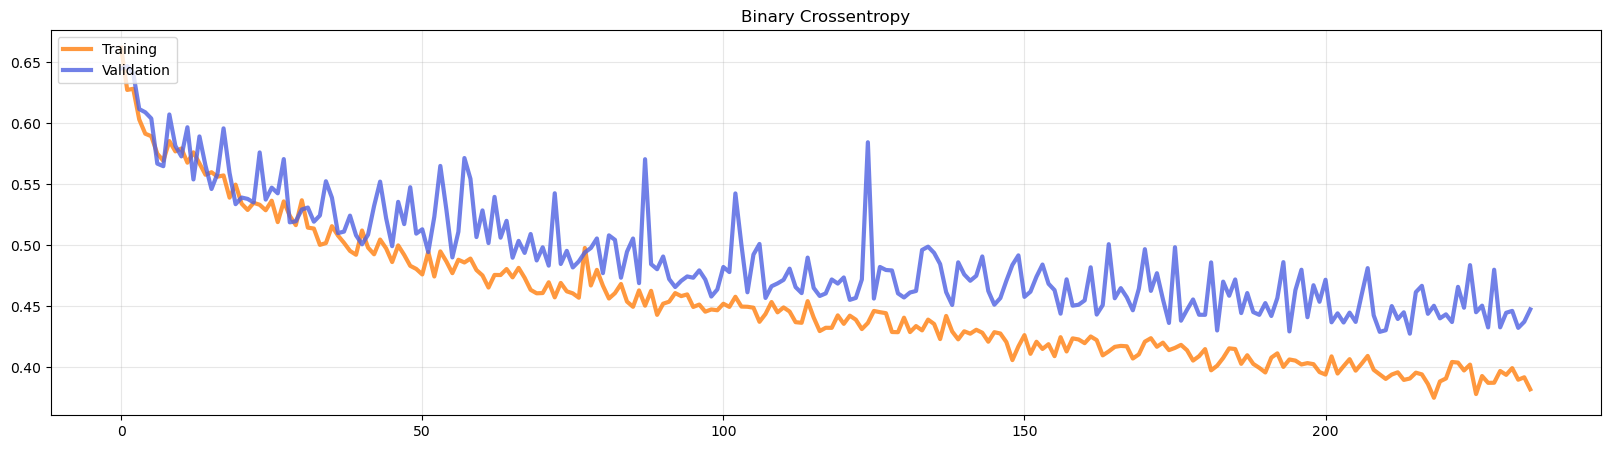

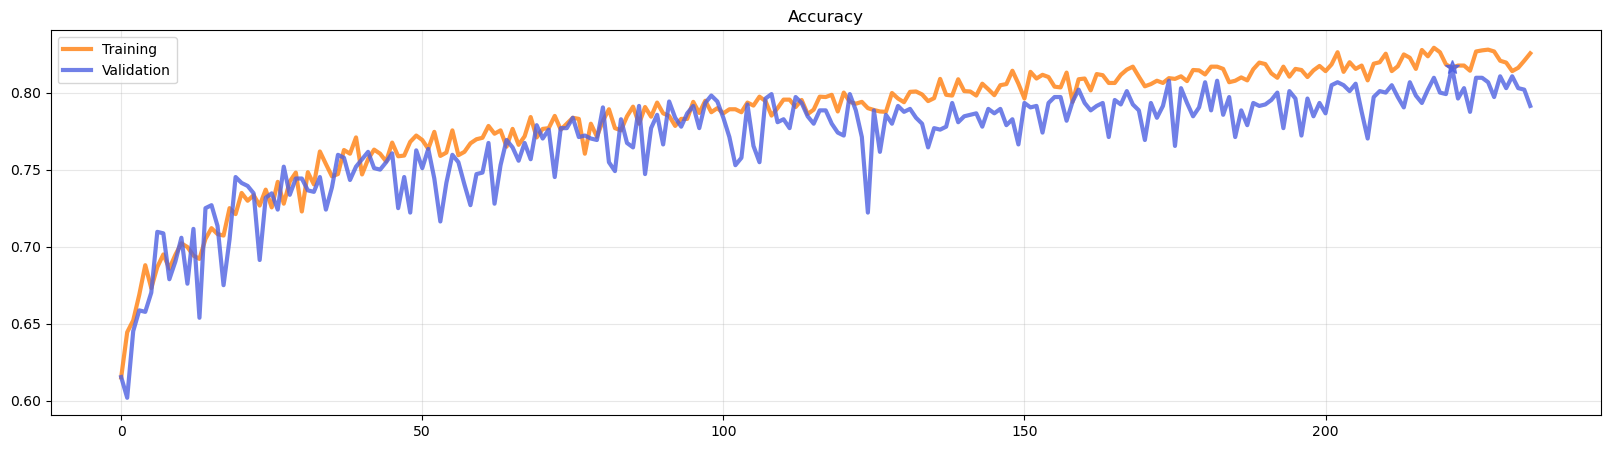

In [9]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [10]:
# Calculate validation accuracy
val_pred = model.predict(X_val, verbose=0)
val_pred = np.argmax(val_pred, axis=-1)
val_true = np.argmax(y_val, axis=-1)
print('Validation accuracy: ', accuracy_score(val_true, val_pred))

Validation accuracy:  0.8067307692307693
